In [84]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os

In [85]:

df = yf.download("AAPL", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [86]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,70.570000,75.360001,69.430000,74.702499,74.002197,341397200
2020-03-03,75.917503,76.000000,71.449997,72.330002,71.651932,319475600
2020-03-04,74.110001,75.849998,73.282501,75.684998,74.975479,219178400
2020-03-05,73.879997,74.887497,72.852501,73.230003,72.543495,187572800
2020-03-06,70.500000,72.705002,70.307503,72.257500,71.580124,226176800


In [87]:
df['Adj Close'].head()

Date
2020-03-02    74.002197
2020-03-03    71.651932
2020-03-04    74.975479
2020-03-05    72.543495
2020-03-06    71.580124
Name: Adj Close, dtype: float64

In [88]:

da = df['Adj Close']
da.describe().round(2)

count    251.00
mean     103.19
std       23.96
min       55.57
25%       79.60
50%      112.17
75%      122.44
max      142.70
Name: Adj Close, dtype: float64

In [89]:
da.head()

Date
2020-03-02    74.002197
2020-03-03    71.651932
2020-03-04    74.975479
2020-03-05    72.543495
2020-03-06    71.580124
Name: Adj Close, dtype: float64

Text(0.5, 1.0, 'Adj Close')

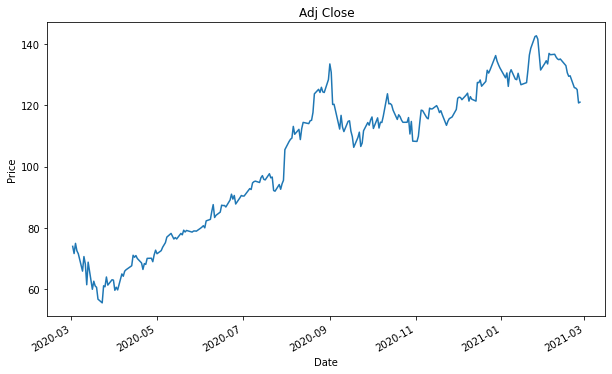

In [90]:
da.plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Adj Close')

In [91]:
da.diff().head().round(2)


Date
2020-03-02     NaN
2020-03-03   -2.35
2020-03-04    3.32
2020-03-05   -2.43
2020-03-06   -0.96
Name: Adj Close, dtype: float64

In [92]:
da.pct_change().round(4).head()

Date
2020-03-02       NaN
2020-03-03   -0.0318
2020-03-04    0.0464
2020-03-05   -0.0324
2020-03-06   -0.0133
Name: Adj Close, dtype: float64

In [93]:
logda = np.log(da / da.shift(1))
logda.head().round(4)

Date
2020-03-02       NaN
2020-03-03   -0.0323
2020-03-04    0.0453
2020-03-05   -0.0330
2020-03-06   -0.0134
Name: Adj Close, dtype: float64

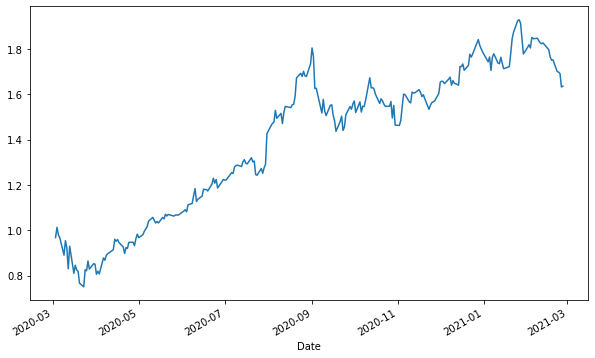

In [94]:
logda.cumsum().apply(np.exp).plot(figsize=(10, 6));


In [95]:
nr = logda.mean() * 252
yvol = logda.std() * (252 ** 0.5)
print('The one year annulized volatility is %.8f' % (yvol))

The one year annulized volatility is 0.45732925


In [96]:
sixlr = logda[126:-1]


In [97]:
snr = sixlr.mean() * 252
svol = sixlr.std() * (252 ** 0.5)
print('The six months annulized volatility is %.8f' % (svol))

The six months annulized volatility is 0.37937673


In [98]:
#average volatility used
vol= (yvol+svol)/2
print('The final annulized volatility is %.8f' % (vol))

The final annulized volatility is 0.41835299


In [99]:
#MONTE CARLOS


In [100]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S


In [101]:
T = 12 
r = 0.0137
sigma = 0.4183
S0 =143
K = 145


In [102]:
S = mcs_simulation_np(1000)


In [103]:
S = np.transpose(S)
S

array([[143.        , 140.82959349, 138.76790118, ...,  93.76576358,
         98.27214157,  99.00581493],
       [143.        , 151.15633308, 153.60219445, ...,  34.93668525,
         36.011234  ,  35.31255038],
       [143.        , 145.85828942, 134.7682634 , ..., 285.76543985,
        291.15866468, 295.9782253 ],
       ...,
       [143.        , 154.03518032, 147.05933864, ...,  18.89232071,
         18.09609978,  17.8150699 ],
       [143.        , 136.25610568, 133.12864   , ...,   4.57196184,
          4.72100382,   4.78836495],
       [143.        , 139.65528713, 150.59726354, ...,  36.03399889,
         35.88951629,  37.5237493 ]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

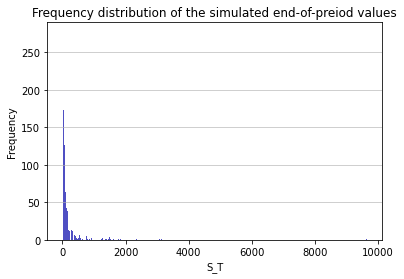

In [104]:

import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [105]:
pp = (K - S[-1,:])>0
bpp = np.mean(np.maximum(pp.astype(int),0))
print('Binary put', str(bpp))

Binary put 0.25074925074925075


In [106]:
#BlackScholes Model 2


In [107]:
def binary_option_bsm(S, K, T, r, q, vol, payoff):
    
    #Sa: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [108]:
binary_option_bsm(143,145,1/12,0.0137,0,0.4183,'put')


0.5652533400129847

In [109]:
S = np.linspace(10,70,11)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = binary_option_bsm(S[i],145,1/12,0.0137,0,0.4183,'put')

In [110]:
pp

array([[0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898],
       [0.99885898]])

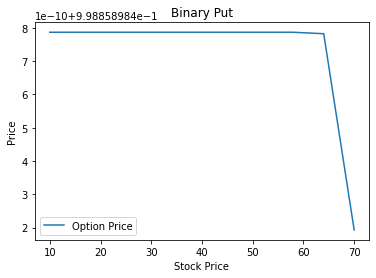

In [111]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('Binary Put')
plt.legend(['Option Price','Payoff at T'])

In [112]:
#GREEKS


In [113]:
#DELTA


In [114]:
def delta(S,k,T,r,q,vol,payoff):
    d1 = (np.log(S/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if payoff == 'call':
        delta =  (np.exp(-r*T))*si.norm.pdf(d2,0.0,1.0)/(vol*S*np.sqrt(T))
    elif payoff == 'put':
        delta = -(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))/(vol*S*np.sqrt(T))

    return delta

In [115]:
delta(143,145,1/12,0.0162,0,0.4183,'put')


-0.022763266906349628

In [116]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 39, T[i], 0.0137,0,0.4183,'put')

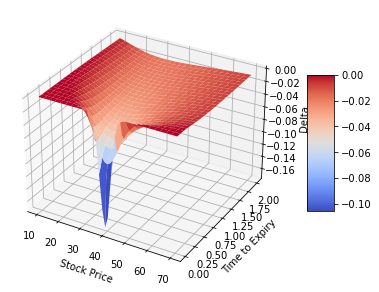

In [117]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);


In [118]:
#GAMMA


In [119]:
def gamma(S,k,T,r,q,vol,payoff):
    d1 = (np.log(S/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if payoff == 'call':
        gamma = (np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*(T))
    elif payoff == 'put':
        gamma = -(np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*(T))

    return gamma

In [120]:
gamma(143,145,1/12,0.0137,0,0.4183,'put')


5.956770782244813e-05

In [121]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 39, T[i], 0.0137,0,0.4183,'put')

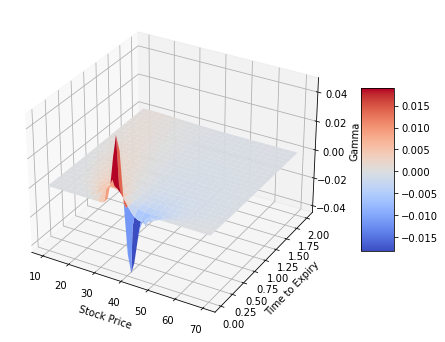

In [122]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);


In [123]:
#THETA


In [124]:
def theta(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a = d1/(2*T)
    b = (r-q)/(vol*np.sqrt(T))
    if payoff == 'call':
        theta = (r* np.exp(-r*T)*(si.norm.cdf(d2,0.0,1.0)))+(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)
    elif payoff == 'put':
        theta = (r* np.exp(-r*T)*(1- si.norm.cdf(d2,0.0,1.0)))-(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)

    return theta

In [125]:
theta(143,145,1/12,0.0137,0.0,0.4183,'put')


0.15890453829438134

In [126]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 39, T[i], 0.0137,0.0,0.4183,'put')
        

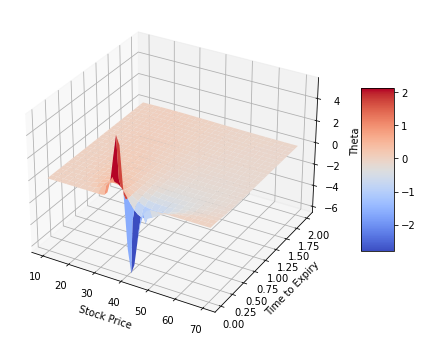

In [127]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [128]:
#SPEED


In [129]:
def speed(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a= (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S0**3)*(T))
    b= ((-2*d1)+((1-(d1*d2))/(vol*np.sqrt(T))))
    
    if payoff == 'call':
        speed = -a*b
    elif payoff == 'put':
        speed = a*b

    return speed

In [130]:
speed(143,145,1/12,0.0137,0,0.4183,'put')


7.659761924352726e-05

In [131]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 39, T[i], 0.0137,0,0.4138,'put')

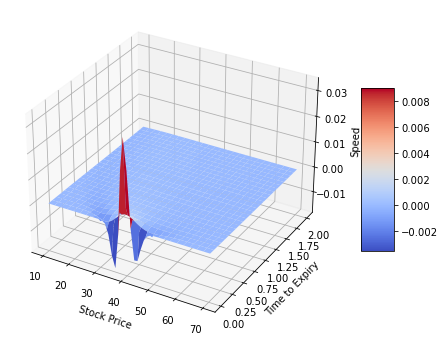

In [132]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [133]:
#VEGA


In [134]:
def vega(S0,k,T,r,q,sig,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * sig **2)*T)/(sig * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * sig **2)*T)/(sig * np.sqrt(T))
    a = (np.sqrt(T) + ((d2)/sig))   
    if payoff == 'call':
        vega = (-np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)) * a
    elif payoff == 'put':
        vega = (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)) * a
            
    return vega

In [135]:
vega(143,145,1/12,0.0137,0,0.4183,'put')


-0.0424609378293648

In [136]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 39, T[i], 0.0137,0,0.4183,'put')

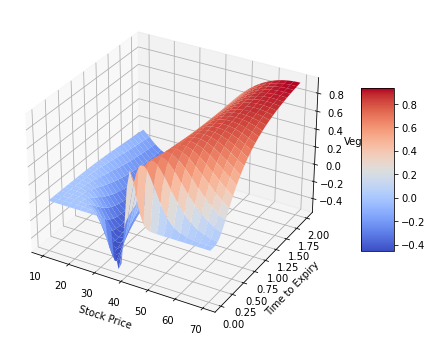

In [137]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);